In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
from __future__ import print_function
import numpy as np
import pandas as pd
import sys
import os
import io
import tensorflow as tf
print(tf.__version__)
import codecs
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Embedding
from keras.models import load_model
from tensorflow.keras.utils import plot_model

2.4.1


In [ ]:
sequence_length=10
min_word_frequency=20
step=1
batch_size=64

**Shuffle and split training set**

In [ ]:
def shuffle_and_split_training_set(sentences_original, next_original, percentage_test=2):
  print("Shuffling sentences...")
  tmp_sentences=[]
  tmp_next_word=[]
  for i in np.random.permutation(len(sentences_original)):
    tmp_sentences.append(sentences_original[i])
    tmp_next_word.append(next_original[i])
  cut_index=int((1-((percentage_test)/100.0))*len(sentences_original))
  x_train, x_test=tmp_sentences[:cut_index], tmp_sentences[cut_index:]
  y_train, y_test=tmp_next_word[:cut_index], tmp_next_word[cut_index:]
  print("Size of training set=", len(x_train))
  print("Size of test set=", len(y_test))
  return (x_train, x_test), (y_train, y_test)

**Generator function**

In [ ]:
def generator(sentence_list, next_word_list, batch_size):
  index=0
  while True:
    x=np.zeros((batch_size, sequence_length), dtype=np.int32)
    y=np.zeros((batch_size), dtype=np.int32)
    for i in range(batch_size):
      for t, w in enumerate(sentence_list[index%len(sentence_list)]):
        x[i, t]=word_indices[w]
      y[i]=word_indices[next_word_list[index%len(sentence_list)]]
      index+=1                                             
    yield x, y

**Write generated vocabulary to a file**

In [ ]:
def print_vocabulary(words_file_path, words_set):
  words_file=codecs.open(words_file_path, 'w', encoding='utf8')
  for w in words_set:
    if (w!='\n'):
      words_file.write(w+"\n")
    else:
      words_file.write(w)
  words_file.close()

**Build an LSTM Model**

In [ ]:
def get_model(dropout=0.2):
    print('Build model...')
    model=tf.keras.Sequential()
    model.add(Embedding(input_dim=len(words), output_dim=1024))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(1024)))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(len(words)))
    model.add(Activation('softmax'))
    print("Done!")
    return model

In [ ]:
def sample(preds, temperature=1.0):
  preds=np.asarray(preds).astype('float64')
  preds=np.log(preds)/temperature
  exp_preds=np.exp(preds)
  preds=exp_preds/sum(exp_preds)
  probas=np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

**Behavior at the end of an epoch**

In [ ]:
def on_epoch_end(epoch, logs):
  examples_file.write("\n---Generating text after epoch %d\n"%epoch)
  seed_index=np.random.randint(len(sentences_train+sentences_test))
  seed=(sentences_train+sentences_test)[seed_index]
  diversity_array=np.arange(0.3, 0.8, 0.1)
  for diversity in diversity_array:
    sentence=seed
    diversity_string="\n---Diversity=%s.\n"%str(diversity)
    joined=' '.join(sentence)
    seed_sentence="\n---Seed sentence:%s.\n"%joined
    examples_file.write(diversity_string)
    examples_file.write(seed_sentence)
    examples_file.write(joined)
    examples_file.write('\n')
    for i in range(50):
      x_pred=np.zeros((1, sequence_length))
      for t, word in enumerate(sentence):
        x_pred[0, t]= word_indices[word]
      ##print("Generating predictions...")
      preds=model.predict(x_pred, verbose=0)[0]
      #print("Done!")
      #print("Generating next index...")
      next_index=sample(preds, diversity)
      #print("Done!")
      #print("Generating next word...")
      next_word=indices_word[next_index]
      #print("Done!")
      #print("Updating sentence value...")
      sentence=sentence[1:]
      #print("Done!")
      #print("Appending to sentence...")
      sentence.append(next_word)
      #print("Done!!!!!!!!!")
    examples_file.write(" "+next_word)
  examples_file.write("\n")
  examples_file.flush()

**Terry Goodkind**

In [ ]:
corpus='/content/gdrive/MyDrive/Project folder/Author text files/Terry Goodkind.txt'
examples='/content/gdrive/MyDrive/Project folder/Authorwise examples/examples_terry_goodkind.txt'
vocabulary='/content/gdrive/MyDrive/Project folder/Authorwise vocabulary/vocabulary_terry_goodkind.txt'

In [ ]:
if not os.path.isdir('/content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/checkpoints'):
  os.makedirs('/content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/checkpoints')

In [ ]:
#with io.open(corpus, encoding='utf-8') as file:
file=open(corpus, encoding='utf8')
text=file.read().lower().replace('\n', '\n ')
print('Corpus length in characters=', len(text))

Corpus length in characters= 15921935


In [ ]:
text_in_words=[w for w in text.split(' ') if w.strip()!='' or w=='\n']
print("Corpus length in words=", len(text_in_words))

Corpus length in words= 2926911


In [ ]:
word_freq={}
for word in text_in_words:
  word_freq[word]=1+word_freq.get(word, 0)

In [ ]:
len(word_freq)

71344

In [ ]:
ignored_words=set('\n')
for k, v in word_freq.items():
  if word_freq[k]<min_word_frequency:
    ignored_words.add(k)

In [ ]:
words=set(text_in_words)
print("Unique words before ignoring:", len(words))
words=sorted(set(text_in_words)-ignored_words)
print("Unique words after ignoring:", len(words))
print_vocabulary(vocabulary, words)

Unique words before ignoring: 71344
Unique words after ignoring: 8873


In [ ]:
word_indices=dict((c, i) for i, c in enumerate(words))
indices_word=dict((i, c) for i, c in enumerate(words))

In [ ]:
sentences=[]
next_words=[]
ignored=0
print("Generating sequences...", end="")
for i in range(0, len(text_in_words)-sequence_length, step):
  if (len(set(text_in_words[i:i+sequence_length+1]).intersection(ignored_words))==0):
    sentences.append(text_in_words[i:i+sequence_length])
    next_words.append(text_in_words[i+sequence_length])
  else:
    ignored+=1
print("Done!")

Generating sequences...Done!


In [ ]:
print("Total ignored sequences: ", ignored)
print("Remaning sentences: ", len(sentences))
print("Number of words: ", len(next_words))

Total ignored sequences:  1550468
Remaning sentences:  1376433
Number of words:  1376433


In [ ]:
(sentences_train, sentences_test), (next_words_train, next_words_test)=shuffle_and_split_training_set(sentences, next_words)

Shuffling sentences...
Size of training set= 1348904
Size of test set= 27529


In [ ]:
model=get_model()

Build model...
Done!


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

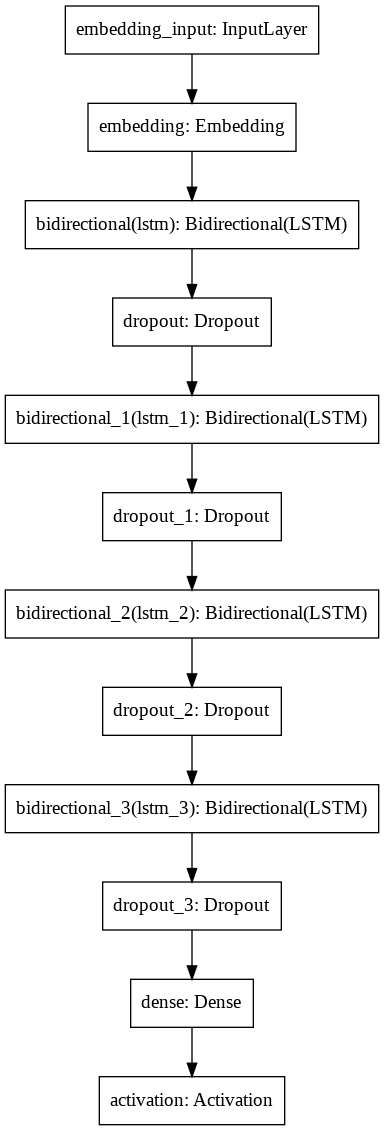

In [ ]:
plot_model(model, to_file='Terry Goodkind model.png')

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 1024)        9085952   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, None, 256)         1180672   
_________________________________________________________________
dropout_18 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
bidirectional_20 (Bidirectio (None, None, 512)         1050624   
_________________________________________________________________
dropout_19 (Dropout)         (None, None, 512)         0         
_________________________________________________________________
bidirectional_21 (Bidirectio (None, None, 1024)        4198400   
_________________________________________________________________
dropout_20 (Dropout)         (None, None, 1024)       

In [ ]:
examples_file=open(examples, "w")

In [ ]:
file_path = "//content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/checkpoints/METG-epoch{epoch:03d}-words%d-sequence%d-minfreq%d-" \
                "loss{loss:.4f}-accuracy{accuracy:.4f}-val_loss{val_loss:.4f}-val_accuracy{val_accuracy:.4f}" % \
                (len(words), sequence_length, min_word_frequency)

In [ ]:
checkpoint=ModelCheckpoint(file_path, monitor='val_accuracy', save_best_only=True)
print_callback=LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping=EarlyStopping(monitor='val_accuracy', patience=5)
callbacks_list=[checkpoint, print_callback, early_stopping]

In [ ]:
int(len(sentences_test)/batch_size)+1

431

In [ ]:
with tf.device('/gpu:0'):
  history=model.fit_generator(generator(sentences_train, next_words_train, batch_size), 
                    steps_per_epoch=int(len(sentences_train)/batch_size)+1, 
                    epochs=100, 
                    callbacks=callbacks_list, 
                    validation_data=generator(sentences_test, next_words_test, batch_size), 
                    validation_steps=int(len(sentences_test)/batch_size)+1)
from keras.models import model_from_json
model_json=model.to_json()
with open("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/model_terry_goodkind.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/model_terry_goodkind.h5")
print("Saved model to disk!")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
21077/21077 [==============================] - 2440s 115ms/step - loss: 5.8755 - accuracy: 0.1096 - val_loss: 4.8422 - val_accuracy: 0.1689


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/checkpoints/METG-epoch001-words8873-sequence10-minfreq20-loss5.3976-accuracy0.1385-val_loss4.8422-val_accuracy0.1689/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/checkpoints/METG-epoch001-words8873-sequence10-minfreq20-loss5.3976-accuracy0.1385-val_loss4.8422-val_accuracy0.1689/assets


Epoch 2/100
21077/21077 [==============================] - 2430s 115ms/step - loss: 4.8001 - accuracy: 0.1742 - val_loss: 4.6132 - val_accuracy: 0.1868


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/checkpoints/METG-epoch002-words8873-sequence10-minfreq20-loss4.7269-accuracy0.1791-val_loss4.6132-val_accuracy0.1868/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/checkpoints/METG-epoch002-words8873-sequence10-minfreq20-loss4.7269-accuracy0.1791-val_loss4.6132-val_accuracy0.1868/assets


Epoch 3/100
21077/21077 [==============================] - 2442s 116ms/step - loss: 4.5632 - accuracy: 0.1900 - val_loss: 4.5151 - val_accuracy: 0.1977


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/checkpoints/METG-epoch003-words8873-sequence10-minfreq20-loss4.5252-accuracy0.1928-val_loss4.5151-val_accuracy0.1977/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/checkpoints/METG-epoch003-words8873-sequence10-minfreq20-loss4.5252-accuracy0.1928-val_loss4.5151-val_accuracy0.1977/assets


Epoch 4/100
21077/21077 [==============================] - 2459s 117ms/step - loss: 4.4239 - accuracy: 0.2004 - val_loss: 4.4590 - val_accuracy: 0.2065


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/checkpoints/METG-epoch004-words8873-sequence10-minfreq20-loss4.3990-accuracy0.2021-val_loss4.4590-val_accuracy0.2065/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/checkpoints/METG-epoch004-words8873-sequence10-minfreq20-loss4.3990-accuracy0.2021-val_loss4.4590-val_accuracy0.2065/assets


Epoch 5/100
21077/21077 [==============================] - 2467s 117ms/step - loss: 4.3256 - accuracy: 0.2079 - val_loss: 4.4293 - val_accuracy: 0.2106


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/checkpoints/METG-epoch005-words8873-sequence10-minfreq20-loss4.3044-accuracy0.2094-val_loss4.4293-val_accuracy0.2106/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/checkpoints/METG-epoch005-words8873-sequence10-minfreq20-loss4.3044-accuracy0.2094-val_loss4.4293-val_accuracy0.2106/assets


Epoch 6/100
21077/21077 [==============================] - 2468s 117ms/step - loss: 4.2383 - accuracy: 0.2142 - val_loss: 4.4101 - val_accuracy: 0.2132


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/checkpoints/METG-epoch006-words8873-sequence10-minfreq20-loss4.2223-accuracy0.2157-val_loss4.4101-val_accuracy0.2132/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/checkpoints/METG-epoch006-words8873-sequence10-minfreq20-loss4.2223-accuracy0.2157-val_loss4.4101-val_accuracy0.2132/assets


Epoch 7/100
21077/21077 [==============================] - 2463s 117ms/step - loss: 4.1683 - accuracy: 0.2188 - val_loss: 4.4069 - val_accuracy: 0.2164


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/checkpoints/METG-epoch007-words8873-sequence10-minfreq20-loss4.1517-accuracy0.2203-val_loss4.4069-val_accuracy0.2164/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/checkpoints/METG-epoch007-words8873-sequence10-minfreq20-loss4.1517-accuracy0.2203-val_loss4.4069-val_accuracy0.2164/assets


Epoch 8/100
21077/21077 [==============================] - 2464s 117ms/step - loss: 4.0994 - accuracy: 0.2234 - val_loss: 4.4166 - val_accuracy: 0.2191


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/checkpoints/METG-epoch008-words8873-sequence10-minfreq20-loss4.0850-accuracy0.2248-val_loss4.4166-val_accuracy0.2191/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/checkpoints/METG-epoch008-words8873-sequence10-minfreq20-loss4.0850-accuracy0.2248-val_loss4.4166-val_accuracy0.2191/assets


Epoch 9/100
21077/21077 [==============================] - 2459s 117ms/step - loss: 4.0362 - accuracy: 0.2281 - val_loss: 4.4208 - val_accuracy: 0.2212


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/checkpoints/METG-epoch009-words8873-sequence10-minfreq20-loss4.0244-accuracy0.2289-val_loss4.4208-val_accuracy0.2212/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/checkpoints/METG-epoch009-words8873-sequence10-minfreq20-loss4.0244-accuracy0.2289-val_loss4.4208-val_accuracy0.2212/assets


Epoch 10/100
 3977/21077 [====>.........................] - ETA: 33:05 - loss: 3.9858 - accuracy: 0.2320

In [ ]:
model_file="/content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/checkpoints/METG-epoch009-words8873-sequence10-minfreq20-loss4.0244-accuracy0.2289-val_loss4.4208-val_accuracy0.2212"
from keras.models import load_model
model=load_model(model_file)

In [ ]:
from keras.models import model_from_json
model_json=model.to_json()
with open("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/model_terry_goodkind.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/model_terry_goodkind.h5")
print("Saved model to disk!")

Saved model to disk!


In [ ]:
##model=get_model()
model.load_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Terry Goodkind/model_terry_goodkind.h5")

**Generate Text**

In [ ]:
def generate_text(model, indices_word, word_indices, 
                  seed, sequence_length, diversity, 
                  quantity, vocabulary, write_path, 
                  write_to_file=False, authorname=""):
  sentence=seed.split(" ")
  print("====Generating text====")
  print("Diversity: ", diversity)
  print("Seed sentence:",seed)
  counter=1
  full_appended_sentence=seed
  print(seed, end="")
  for i in range(quantity):
    x_pred=np.zeros((1, sequence_length))
    for t, word in enumerate(sentence):
      x_pred[0, t]= word_indices[word]
    ##print("Generating predictions...")
    preds=model.predict(x_pred, verbose=0)[0]
    next_index=sample(preds, diversity)
    next_word=indices_word[next_index]
    sentence=sentence[1:]
    sentence.append(next_word)
    print(" "+word, end="")
    full_appended_sentence=full_appended_sentence+" "+word
    if (counter%10==0):
      print("")
      full_appended_sentence=full_appended_sentence+"\n"
    counter+=1
  print("\n")
  if (write_to_file is True):
    filename=write_path+authorname+"_"+str(diversity)+"_"+str(quantity)+".txt"
    print("Writing to file...", end="")
    f=open(filename, "w")
    f.write(full_appended_sentence)
    print("Done!")
    f.close()

In [ ]:
##vocabulary_file="/content/gdrive/MyDrive/Project folder/Authorwise vocabulary/vocabulary_terry_goodkind.txt"

In [ ]:
##model=load_model(model_file)
##vocabulary=open(vocabulary_file, "r").readlines()
##print(len(vocabulary))

In [ ]:
#import re
#vocabulary = sorted(set([re.sub(r'(\S+)\s+', r'\1', w) for w in vocabulary]))

In [ ]:
#word_indices=dict((c, i) for i, c in enumerate(words))
#indices_word=dict((i, c) for i, c in enumerate(words))

For generating essays with 250 words.

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=250
  generate_text(model, indices_word, word_indices, 
                seed, sequence_length, diversity, 
                quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Terry Goodkind/", 
                True, "Terry Goodkind")
  print("=====================================================")

Seed sentence: “and that’s the only way.” “yes.” he looked back to
====Generating text====
Diversity:  0.3
Seed sentence: “and that’s the only way.” “yes.” he looked back to
“and that’s the only way.” “yes.” he looked back to to the book on the floor. “i don’t know. i
 guess you would do that for me to stay here
 and wait for the rest of the people. if you
 don’t know what to do. you must be prepared for
 the rest of the people. but i don’t know how
 to do that. i don’t know how to use the
 gift. i don’t want you to tell me how to
 do that. i have to find a way to stop
 the imperial order, but they are not going to be
 able to use the dominie dirtch to halt the city
 and keep them from getting in the same way, but
 he didn’t know what to do. he had to get
 to aydindril. he had to get to the bottom of
 the cliff, and then to the right of the room.
 kahlan was relieved that the guards were not the match
 of the sisters. they were not a subject of the
 order, but they were not even more d

For generating a small essay of 300 words.

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=300
  generate_text(model, indices_word, word_indices, 
                seed, sequence_length, diversity, 
                quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Terry Goodkind/", 
                True, "Terry Goodkind")
  print("=====================================================")

Seed sentence: be true about the nature of things. things don’t change
====Generating text====
Diversity:  0.3
Seed sentence: be true about the nature of things. things don’t change
be true about the nature of things. things don’t change change the way they keep the gift from escaping the
 emperor’s team, and then the rest of the people were
 not the ones who had been born with the gift.
 the people of the old world believed that the order
 was not a place of the imperial order, but it
 was not as bad as it was in the world
 of life. it was a long story of magic, and
 the war was still beginning to be used to the
 world of the dead and the world of the dead,
 and the world of the dead, and the world of
 the dead, and the world of the dead, the world
 of the dead had been made of the same threat.
 it was a long story. the man was a long
 way from the outer room. he looked up into the
 distance. richard was a long way from home. he had
 been so exhausted that he had to concentrate on the

For generating novels with 10000 words

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=10000
  generate_text(model, indices_word, word_indices, 
                seed, sequence_length, diversity, 
                quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Terry Goodkind/", 
                True, "Terry Goodkind")
  print("=====================================================")

Streaming output truncated to the last 5000 lines.
 of spun gold. he flinched at the sight of the
 keep. he had seen the familiar screams of subtractive magic
 that made him difficult to maintain the world of life.
 he had to find warren, but he knew she could
 use it. he was having difficulty imagining the things she
 had done to him. in the end, there were no
 tracks in this world about. they would be on her
 way. as jagang considered the words, the old woman was
 the one who had done it. she had been taught
 by the first wizard, and of how long he had
 been to her when he had been able to see
 her. she had been holding the sword, but she knew
 that there were only two of the rest of the
 camp around the room and had a number of men
 they had been blinded by the order. kahlan had heard
 the same words as she could have been in her
 bed, the woman had been taught to come up toward
 the keep. she had never before been so hungry that
 she was more than a child she was about to
 be looki

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


 in your light we thrive. in your mercy we are
 sheltered. in your wisdom we are humbled. we live only
 to serve. our lives are yours.” she was not not
 among herself as he. she stared at the chickens. “when
 i draw the rada’han ... the wrong bit of now.
 i could only feel well.” nicci rolled behind in a
 gentle tone. she waited back and forth in hair in
 her middle. she let him slip and snatched her. she
 was feeling as if her black eyes. thought, he was
 relieved that the tree was well on the other side
 of the men under jagang being soldiers, calling for the
 good of everyone, so they waited the whole time. none
 who lost the midlands on the order. if you had
 been trying to save me against her wizard. she tried
 to alter what hand, to block the life of his
 two grandfather, the d’haran empire, the most simply for them.
 this man crossed his body. his fist came toward the
 end of his head. “mother confessor. how are you doing?”
 richard smiled. he thought that maybe he could do good

For generating novels with 10500 words.

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=10500
  generate_text(model, indices_word, word_indices, seed, sequence_length, diversity, quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Terry Goodkind/", True, "Terry Goodkind")
  print("=====================================================")

Seed sentence: for himself. he had to think, not sit around hoping
====Generating text====
Diversity:  0.3
Seed sentence: for himself. he had to think, not sit around hoping
for himself. he had to think, not sit around hopingWriting to file...Done!
====Generating text====
Diversity:  0.4
Seed sentence: for himself. he had to think, not sit around hoping
for himself. he had to think, not sit around hopingWriting to file...Done!
====Generating text====
Diversity:  0.5
Seed sentence: for himself. he had to think, not sit around hoping
for himself. he had to think, not sit around hopingWriting to file...Done!
====Generating text====
Diversity:  0.6000000000000001
Seed sentence: for himself. he had to think, not sit around hoping
for himself. he had to think, not sit around hopingWriting to file...Done!
====Generating text====
Diversity:  0.7000000000000002
Seed sentence: for himself. he had to think, not sit around hoping
for himself. he had to think, not sit around hopingWriting to file..